# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
print(final.shape)
final=final.sort_values(by=['Time'])
final = final.reset_index(drop=True)
#How many positive and negative reviews are present in our dataset?
final=final.drop('Score', axis = 1)

(46071, 10)


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
Speaking as another Texan, I think the first rule for these delicious treats is to NOT order them during spring or summer. In fact, your safest bet is to ONLY order them in the dead of winter.  LOL!  As long as you do that, be prepared for a truly amazing treat!  This package comes with 12 bite-sized delicacies.  The chocolate is high-quality, the nuts are crunchy, and the overall taste couldn't be better.  Definitely worth the price!
Fast, easy and definitely delicious.  Makes a great cup of coffee and very easy to make.  Good purchase.  Will continue to order from here.<br />Thanx...
Naturally this review is based upon my cat's intake of Petite Cuisine. She's not a particular picky eater, so I can't say much about that. However, she looks to really enjoy this brand of cat food. I have tried some brands of wet food in 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
Speaking as another Texan, I think the first rule for these delicious treats is to NOT order them during spring or summer. In fact, your safest bet is to ONLY order them in the dead of winter.  LOL!  As long as you do that, be prepared for a truly amazing treat!  This package comes with 12 bite-sized delicacies.  The chocolate is high-quality, the nuts are crunchy, and the overall taste couldn't be better.  Definitely worth the price!
Fast, easy and definitely delicious.  Makes a great cup of coffee and very easy to make.  Good purchase.  Will continue to order from here.Thanx...
Naturally this review is based upon my cat's intake of Petite Cuisine. She's not a particular picky eater, so I can't say much about that. However, she looks to really enjoy this brand of cat food. I have tried some brands of wet food in the pa

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Fast, easy and definitely delicious.  Makes a great cup of coffee and very easy to make.  Good purchase.  Will continue to order from here.<br />Thanx...


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Fast easy and definitely delicious Makes a great cup of coffee and very easy to make Good purchase Will continue to order from here br Thanx 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:17<00:00, 2572.46it/s]


In [0]:
preprocessed_reviews[1500]

'fast easy definitely delicious makes great cup coffee easy make good purchase continue order thanx'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 39364)
the number of unique words  39364


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able figure', 'able find']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 27311)
the number of unique words including both unigrams and bigrams  27311


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8307234048843384), ('fantastic', 0.8258373141288757), ('good', 0.8159111142158508), ('terrific', 0.8059110045433044), ('excellent', 0.8041128516197205), ('wonderful', 0.7852914929389954), ('amazing', 0.7624056935310364), ('perfect', 0.7424131035804749), ('nice', 0.6960139870643616), ('fabulous', 0.6763274669647217)]
[('nastiest', 0.8041174411773682), ('greatest', 0.747943639755249), ('best', 0.7293623089790344), ('tastiest', 0.7000325322151184), ('hottest', 0.6701523065567017), ('experienced', 0.6504215598106384), ('nicest', 0.6173108220100403), ('ive', 0.6136384010314941), ('closest', 0.5998547673225403), ('disgusting', 0.5858423113822937)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12798
sample words  ['shin', 'ran', 'optimistic', 'lifestyle', 'curve', 'decent', 'awsome', 'become', 'oatmeals', 'curly', 'ironically', 'speeds', 'freeze', 'buffet', 'pampered', 'bodybuilding', 'cramps', 'waking', 'chris', 'dry', 'itching', 'henry', 'downside', 'painful', 'survives', 'petstore', 'hydration', 'politically', 'illegal', 'inspection', 'youth', 'nobody', 'goldens', 'fourth', 'spaniel', 'gerd', 'solely', 'dive', 'spoilage', 'applewood', 'guayaki', 'olewo', 'grade', 'crystal', 'latter', 'dances', 'grinds', 'rock', 'tho', 'popchips']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 46071/46071 [06:43<00:00, 114.20it/s]

46071
50


In [0]:
x=preprocessed_reviews[:10000]

In [0]:
list_of_sentance_10k=[]
for sentance in x:
    list_of_sentance_10k.append(sentance.split())

In [0]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_10k=Word2Vec(list_of_sentance_10k,min_count=5,size=50, workers=4)
    print(w2v_model_10k.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_10k.wv.most_similar('worst'))
    

[('good', 0.9173808097839355), ('excellent', 0.8200935125350952), ('quick', 0.7732078433036804), ('super', 0.7619392275810242), ('wonderful', 0.7497603297233582), ('awesome', 0.7436496019363403), ('reasonable', 0.7303093671798706), ('pizzas', 0.7286679744720459), ('yummy', 0.7243077158927917), ('object', 0.7240973711013794)]
[('encountered', 0.9859185814857483), ('ive', 0.9846028089523315), ('salts', 0.9844100475311279), ('spirit', 0.9838737845420837), ('oberto', 0.9838624000549316), ('superior', 0.983829140663147), ('greatest', 0.9837797284126282), ('heinz', 0.9837124347686768), ('searching', 0.9835888743400574), ('varieties', 0.9830135703086853)]


In [0]:
w2v_words_10k = list(w2v_model_10k.wv.vocab)

In [0]:
sent_vectors_10k = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_10k): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_10k:
            vec = w2v_model_10k.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_10k.append(sent_vec)
print(len(sent_vectors_10k))

print(len(sent_vectors_10k))

100%|██████████| 10000/10000 [00:29<00:00, 343.19it/s]

10000
10000


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 46071/46071 [23:41<00:00, 48.50it/s] 


In [0]:
model2 = TfidfVectorizer()
tf_idf_matrix = model2.fit_transform(preprocessed_reviews[:10000])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model2.get_feature_names(), list(model2.idf_)))

In [0]:
tfidf_feat = model2.get_feature_names() 

tfidf_sent_vectors_10k = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_10k): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_model_10k and word in tfidf_feat:
            vec = w2v_model_10k.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_10k.append(sent_vec)
    row += 1

100%|██████████| 10000/10000 [01:33<00:00, 106.47it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

In [0]:
from sklearn.cluster import KMeans

k_value=[x for x in range(2,11)]

def best_k(CV):
    intercluster_dist=[]
    for i in k_value:
        
        clf=KMeans(n_clusters=i,n_jobs=-1)
        clf.fit(CV)
        
        intercluster_dist.append(clf.inertia_)
        
    k_best=k_value[np.argmin(intercluster_dist)]
    
    print("The best value of k comes out to be :",k_best)
    print("The least value of intercluster distance comes out to be:",np.min(intercluster_dist))
    
    plt.plot(k_value, intercluster_dist)
    plt.title("Intercluster distance vs Number of clusters.")
    plt.xlabel("Number of clusters.")
    plt.ylabel("Intercluster distance")
    
def kmeans(data,i):
    
    clf=KMeans(n_clusters=i,n_jobs=-1)
    clf.fit(data)
    
    return clf

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

The best value of k comes out to be : 10
The least value of intercluster distance comes out to be: 788919.1238865328


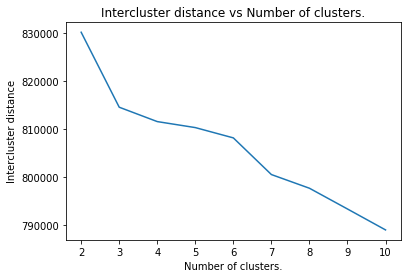

In [0]:
best_k(final_counts[:15000])



In [0]:
model=kmeans(final_counts,10)

In [0]:

labels=final.iloc[:46071]

In [0]:
labels['Cluster']=model.labels_

**Number of words per culster**


In [0]:
labels.Cluster.value_counts()

0    28166
9     9801
8     2096
2     1715
6     1392
7     1346
4      865
1      259
5      216
3      215
Name: Cluster, dtype: int64

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

Top terms per cluster:
Cluster 0:

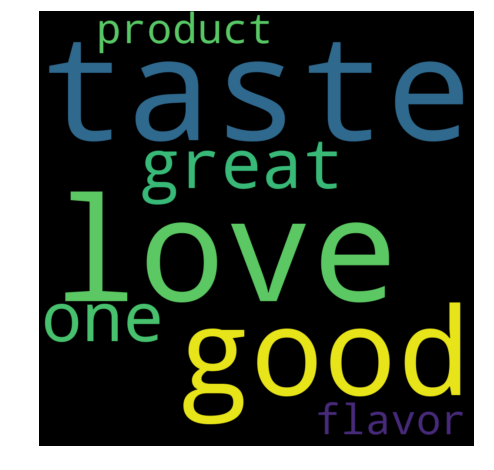

Cluster 1:

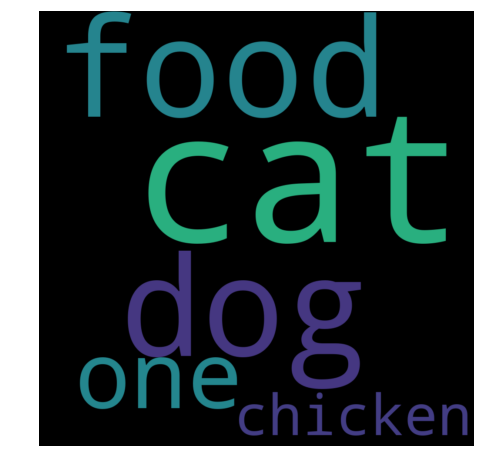

Cluster 2:

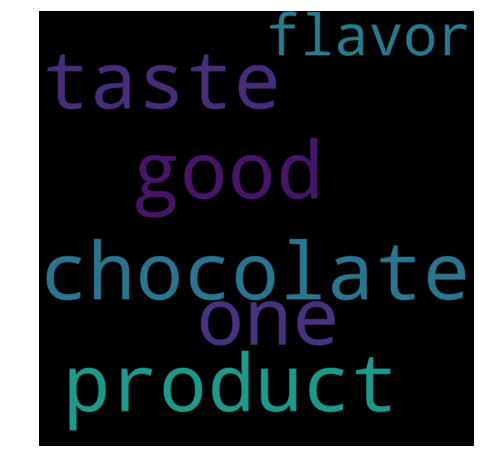

Cluster 3:

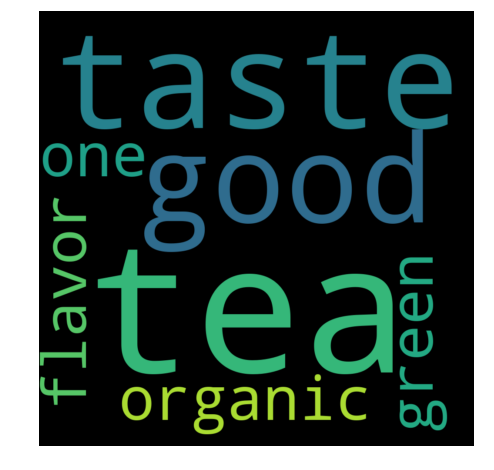

Cluster 4:

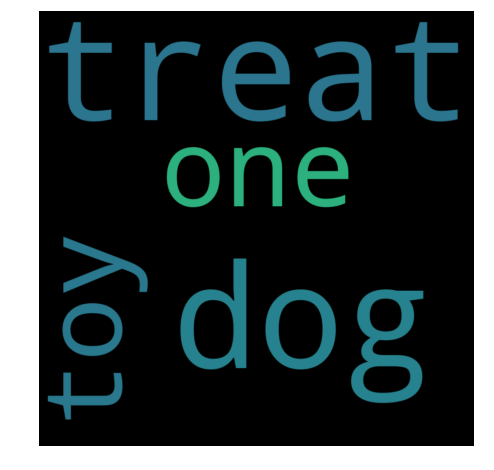

Cluster 5:

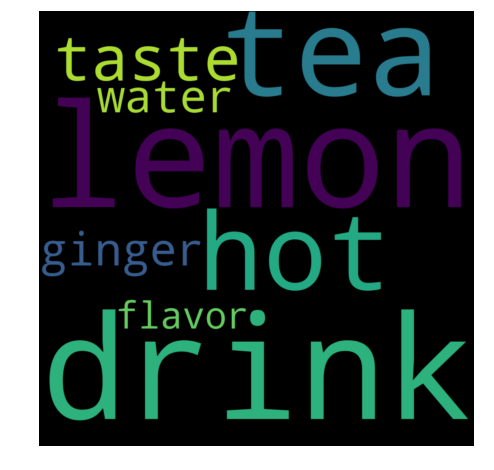

Cluster 6:

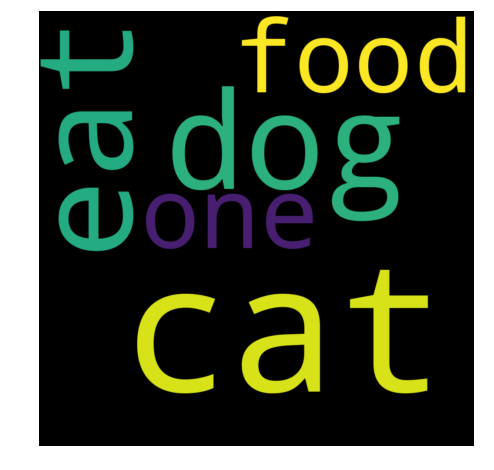

Cluster 7:

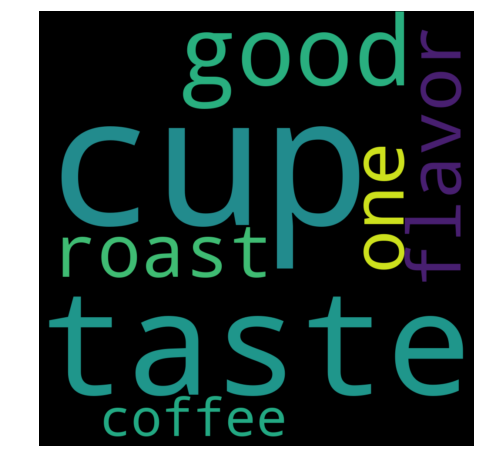

Cluster 8:

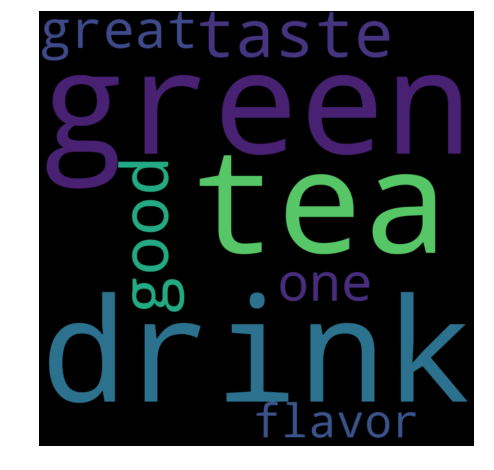

Cluster 9:

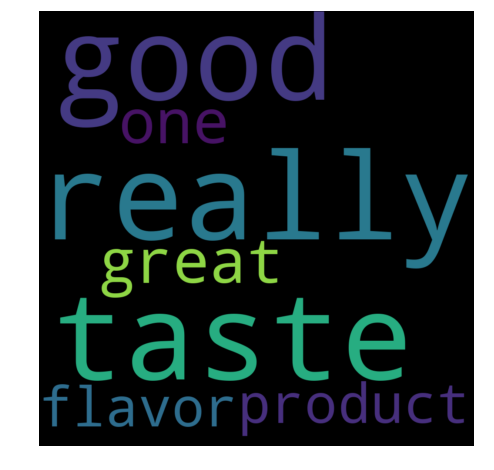

In [0]:
from wordcloud import WordCloud

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = count_vect.get_feature_names()
for i in range(10):
    print("Cluster %d:" % i, end='')
    text=""
    for ind in order_centroids[i, :10]:
        text = text + " " + terms[ind]
  
    wordcloud = WordCloud(width=1000, height=1000, max_words=20).generate(text) 

    # plot the WordCloud image  
    plt.figure(figsize=(8,8))
    plt.subplot()
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis("off") 
    plt.margins(x=0, y=0) 
    plt.show() 

**CLUSTER REPRESENTATION**

CLUSTER 0 : POSITIVE AND QUALITATIVE ADJECTIVES<BR>
CLUSTER 1: ANIMALS<BR>
CLUSTER 2: QUALITATIVE ADJECTIVES<BR>
CLUSTER 3: TEA REALTED WORDS/QUALITATIVE ADJECTIVES<BR>
CLUSTER 4: UNCLEAR<BR>
CLUSTER 5: TEA RELATED WORDS <BR>
CLUSTER 6: ANIMALS/NUANCED WORDS<BR>
CLUSTER 7: COFFEE REALTED WORDS<BR>
CLUSTER 8: TEA REALTED WORDS<BR>
CLUSTER 9: POSITIVE QUALITATIVE ADJECTIVE<BR>

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

The best value of k comes out to be : 10
The least value of intercluster distance comes out to be: 14455.849841090345


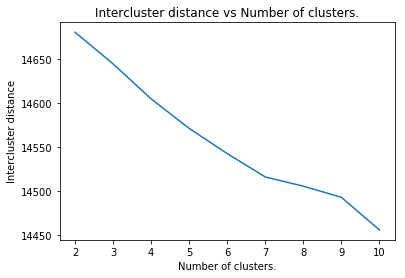

In [0]:
best_k(final_tf_idf[:15000])

In [0]:
model=kmeans(final_tf_idf,10)

In [0]:
labels=final.iloc[:46071]

In [0]:
labels['Cluster']=model.labels_

**Number of words per culster**

In [0]:
labels.Cluster.value_counts()

5    17239
2     8207
6     4792
4     4387
7     3619
1     2928
0     1674
9     1646
3     1078
8      501
Name: Cluster, dtype: int64

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

Top terms per cluster:
Cluster 0:

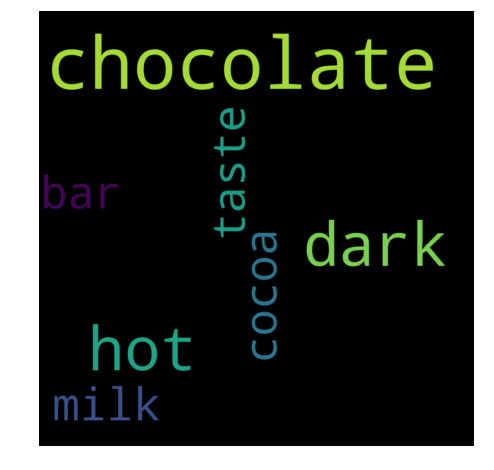

Cluster 1:

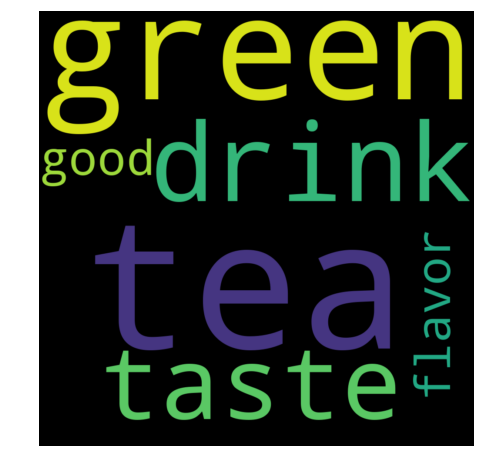

Cluster 2:

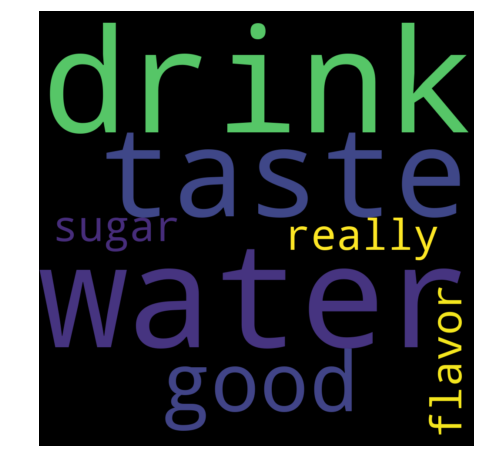

Cluster 3:

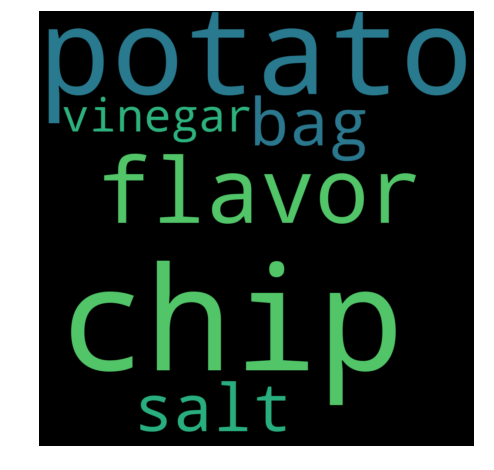

Cluster 4:

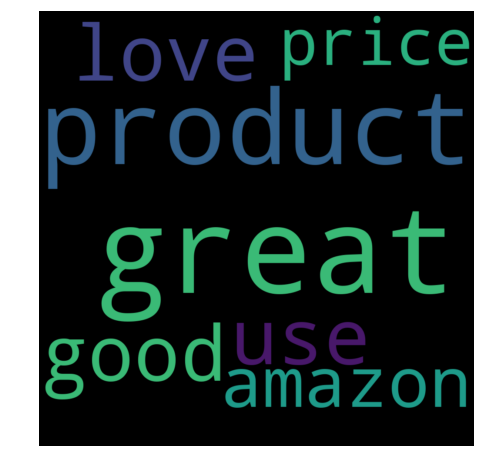

Cluster 5:

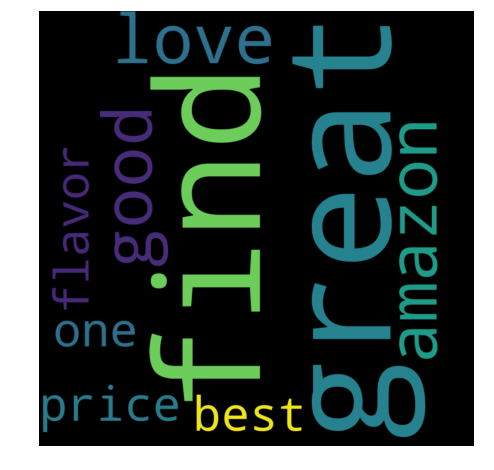

Cluster 6:

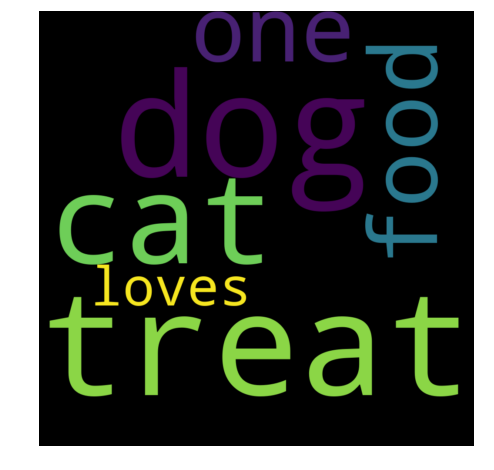

Cluster 7:

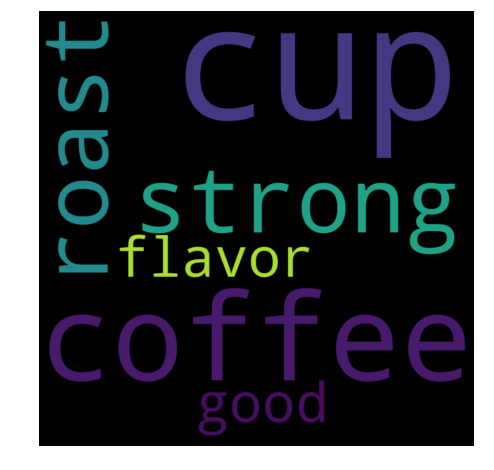

Cluster 8:

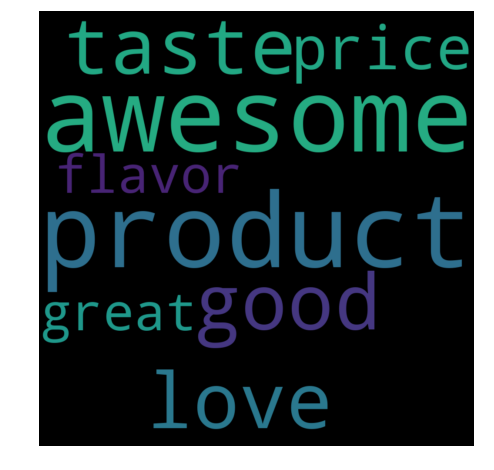

Cluster 9:

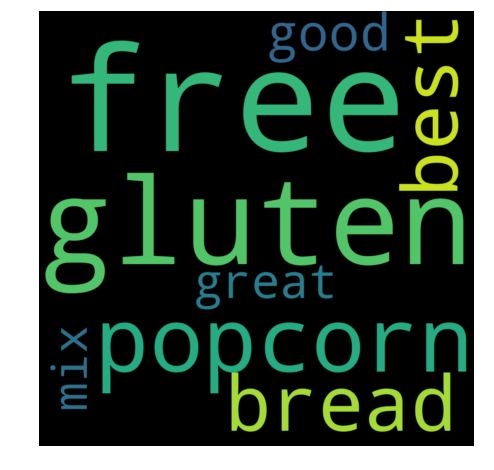

In [0]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf_vect.get_feature_names()
for i in range(10):
    print("Cluster %d:" % i, end='')
    text=""
    for ind in order_centroids[i, :10]:
        text = text + " " + terms[ind]
  
    wordcloud = WordCloud(width=1000, height=1000, max_words=20).generate(text) 

    # plot the WordCloud image  
    plt.figure(figsize=(8,8))
    plt.subplot()
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis("off") 
    plt.margins(x=0, y=0) 
    plt.show() 

**CLUSTER REPRESENTATION**

CLUSTER 0 : TEA REALTED WORDS<BR>
CLUSTER 1: POSTIVE ADJECTIVES ON DRINKS<BR>
CLUSTER 2: POTATO CHIPS WORDS<BR>
CLUSTER 3: PRODUCT ADJECTIVES<BR>
CLUSTER 4: POSITIVE ADJECTIVES<BR>
CLUSTER 5: POSITIVE QUALITATIVE ADJECTIVES<BR>
CLUSTER 6: UNCLEAR<BR>
CLUSTER 7: COFFEE REALTED WORDS<BR>
CLUSTER 8: POSITIVE ADJECTIVES<BR>
CLUSTER 9: FOOD REALTED WORDS<BR>

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

The best value of k comes out to be : 10
The least value of intercluster distance comes out to be: 74479.26000397398


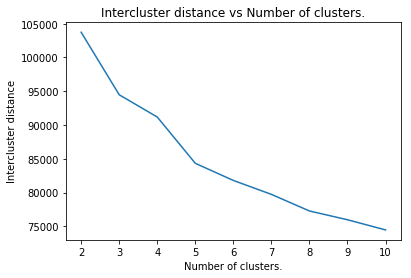

In [0]:
best_k(sent_vectors[:15000])

In [0]:
model=kmeans(sent_vectors,10)

In [0]:
labels=final.iloc[:46071]

In [0]:
labels['Cluster']=model.labels_

**Number of words per culster**

In [0]:
labels.Cluster.value_counts()

0    28166
9     9801
8     2096
2     1715
6     1392
7     1346
4      865
1      259
5      216
3      215
Name: Cluster, dtype: int64

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

Top terms per cluster:
Cluster 0:

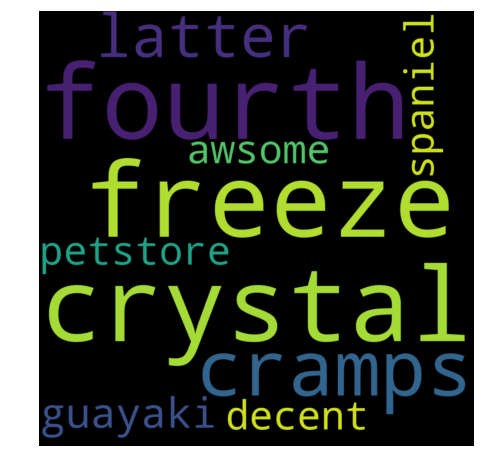

Cluster 1:

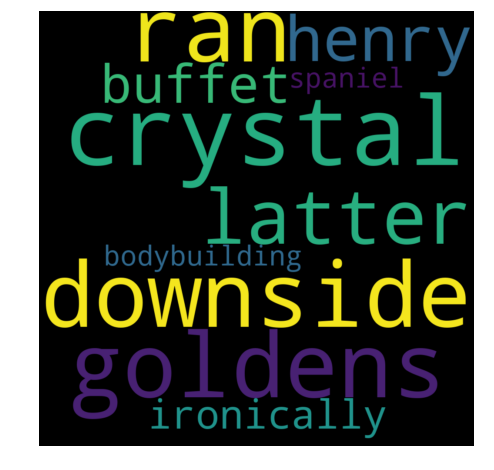

Cluster 2:

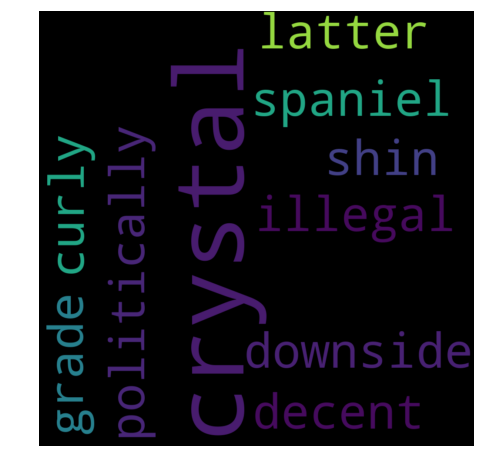

Cluster 3:

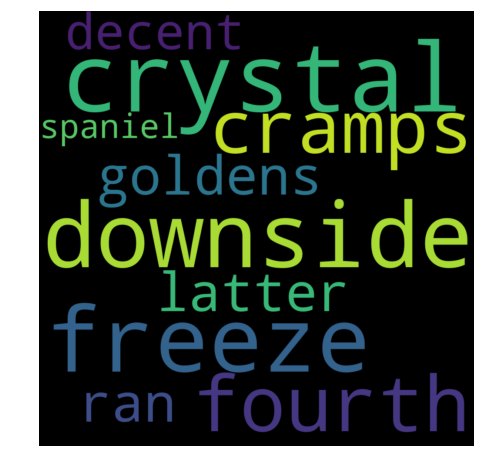

Cluster 4:

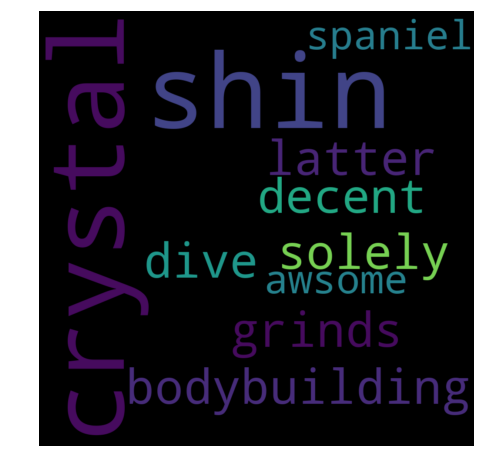

Cluster 5:

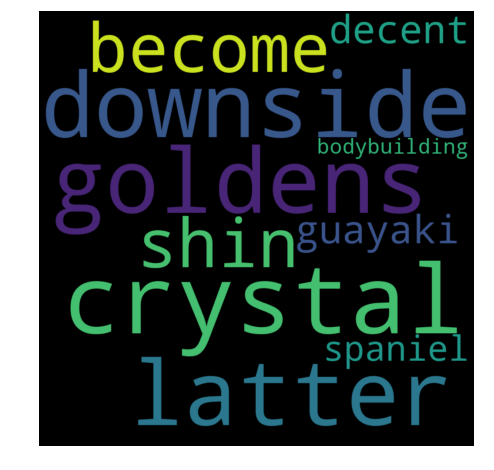

Cluster 6:

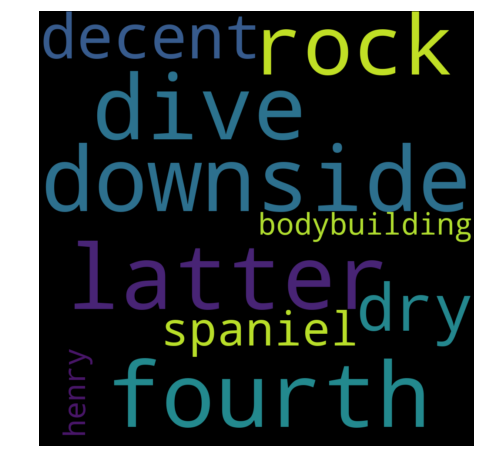

Cluster 7:

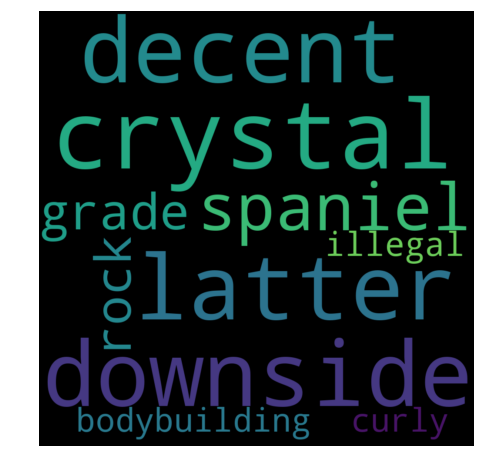

Cluster 8:

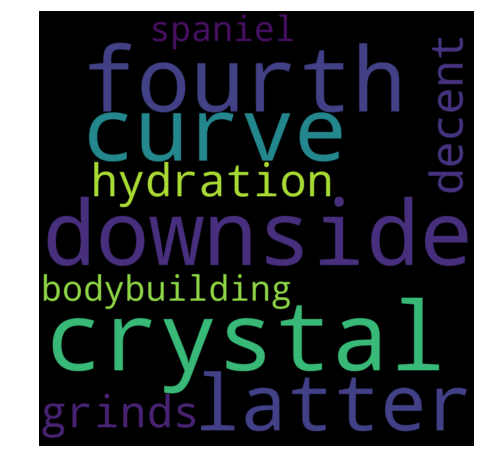

Cluster 9:

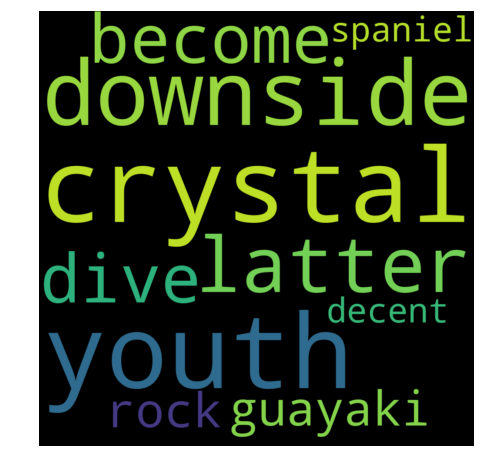

In [0]:
from wordcloud import WordCloud

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = w2v_words
for i in range(10):
    print("Cluster %d:" % i, end='')
    text=""
    for ind in order_centroids[i, :10]:
        text = text + " " + terms[ind]
  
    wordcloud = WordCloud(width=1000, height=1000, max_words=20).generate(text) 

    # plot the WordCloud image  
    plt.figure(figsize=(8,8))
    plt.subplot()
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis("off") 
    plt.margins(x=0, y=0) 
    plt.show() 

**CLUSTER REPRESENTATION**

UNCLEAR AND VERY NUANCED REALTED WORDS IN EVERY CLUSTER


### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

The best value of k comes out to be : 10
The least value of intercluster distance comes out to be: 96446.71117109332


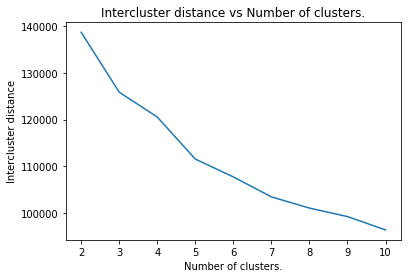

In [0]:
best_k(tfidf_sent_vectors[:15000])

In [0]:
model=kmeans(tfidf_sent_vectors,10)

In [0]:
labels=final.iloc[:46071]

In [0]:
labels['Cluster']=model.labels_

**Number of words per culster**

In [0]:
labels.Cluster.value_counts()

7    11498
4     5752
1     5387
3     5361
2     4851
5     3785
6     3282
0     3154
8     1976
9     1025
Name: Cluster, dtype: int64

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

Top terms per cluster:
Cluster 0:

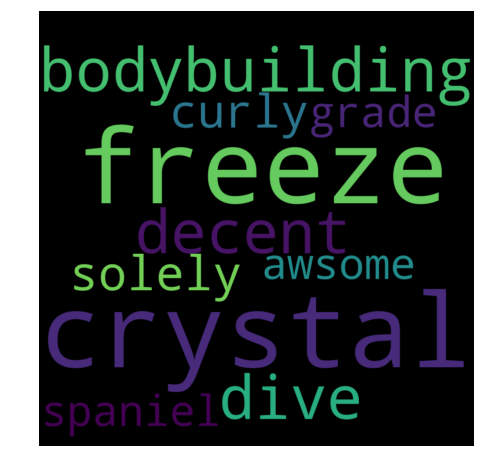

Cluster 1:

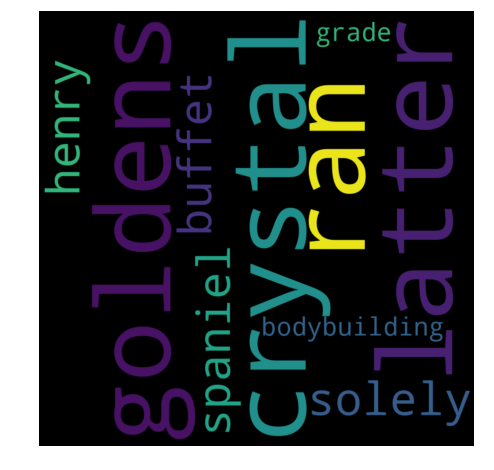

Cluster 2:

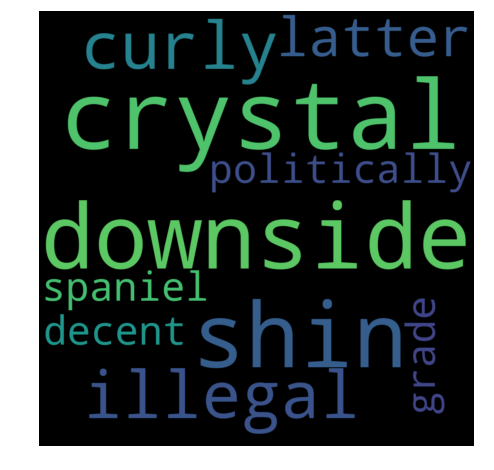

Cluster 3:

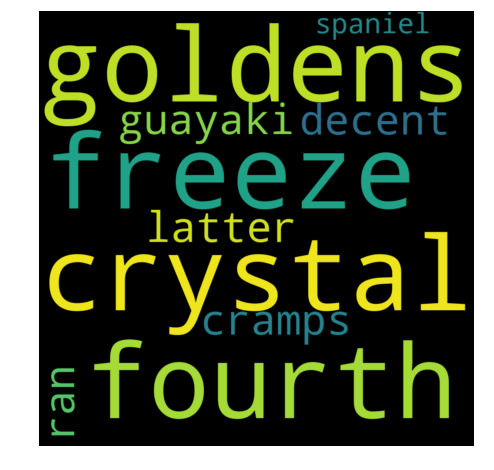

Cluster 4:

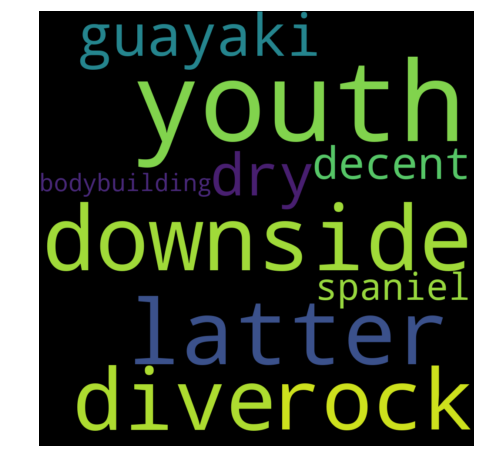

Cluster 5:

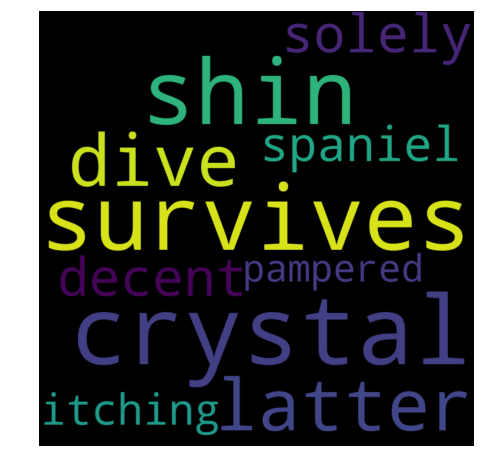

Cluster 6:

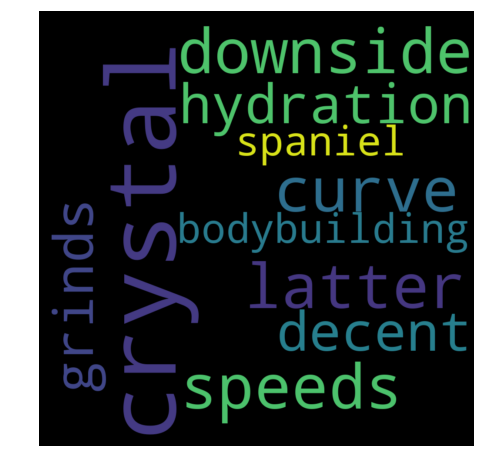

Cluster 7:

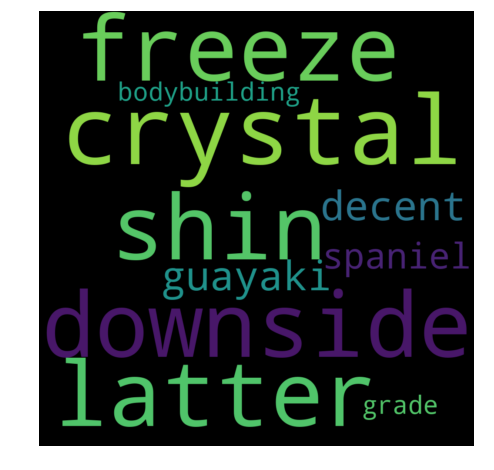

Cluster 8:

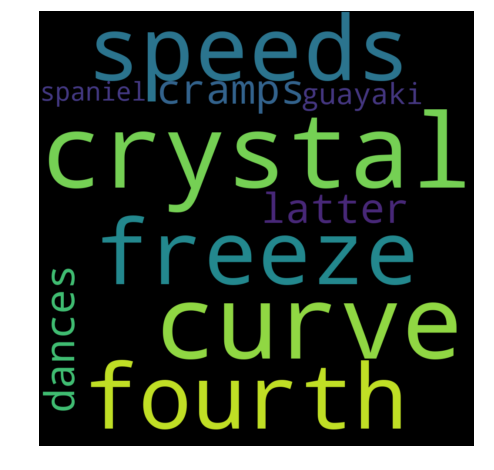

Cluster 9:

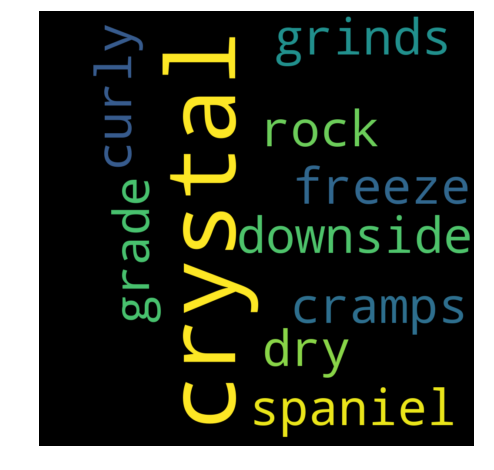

In [0]:
from wordcloud import WordCloud

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = w2v_words
for i in range(10):
    print("Cluster %d:" % i, end='')
    text=""
    for ind in order_centroids[i, :10]:
        text = text + " " + terms[ind]
  
    wordcloud = WordCloud(width=1000, height=1000, max_words=20).generate(text) 

    # plot the WordCloud image  
    plt.figure(figsize=(8,8))
    plt.subplot()
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis("off") 
    plt.margins(x=0, y=0) 
    plt.show() 

**CLUSTER REPRESENTATION**

UNCLEAR AND VERY NUANCED REALATION BETWEEN WORDS IN EACH CLUSTER

In [0]:
# Please write all the code with proper documentation

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [0]:
from sklearn.cluster import AgglomerativeClustering

model=AgglomerativeClustering(n_clusters=2,linkage='ward')
model.fit(sent_vectors_10k)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x7fe16c082268>)

In [0]:
labels=final.iloc[:10000]

In [0]:
labels["Cluster"]=model.labels_

**Number of words per culster**

In [0]:
labels.Cluster.value_counts()

1    5076
0    4924
Name: Cluster, dtype: int64

In [0]:
cluster_0=labels.iloc[labels.groupby(["Cluster"]).groups[0]]["Text"]
cluster_1=labels.iloc[labels.groupby(["Cluster"]).groups[1]]["Text"]

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

Word-cloud for cluster- 0


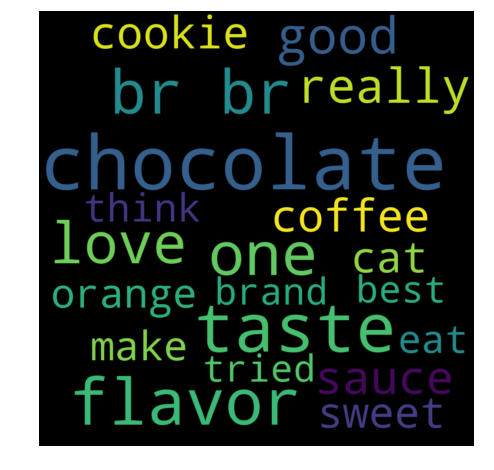

Word-cloud for cluster- 1


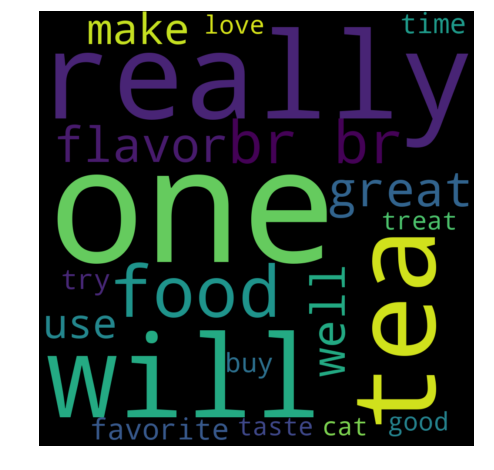

In [0]:
cluster_0=list(cluster_0)[:50]
cluster_1=list(cluster_1)[:50]

clusters=(cluster_0,cluster_1)
for i in range(0,2):
        print("Word-cloud for cluster-",i)
        text=""
        for x in clusters[i]:
             text = text + " " + x
        wordcloud = WordCloud(width=1000, height=1000, max_words=20).generate(text) 

        plt.figure(figsize=(8,8))
        plt.subplot()
        plt.imshow(wordcloud, interpolation="bilinear") 
        plt.axis("off") 
        plt.margins(x=0, y=0) 
        plt.show() 


**CLUSTER REPRESENTATION**

CLUSTER 0 : POSTIVE QUALITATIVE ADJECTIVES WITH FOOD ITEMS<BR>
CLUSTER 1: POSTIVE ADJECTIVES/NUANCED WORDS<BR>


### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
model=AgglomerativeClustering(n_clusters=2,linkage='ward')
model.fit(tfidf_sent_vectors_10k)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x7fe16c082268>)

In [0]:
labels=final.iloc[:10000]

In [0]:
labels["Cluster"]=model.labels_

**Number of words per culster**

In [0]:
labels.Cluster.value_counts()

0    7736
1    2264
Name: Cluster, dtype: int64

In [0]:
cluster_0=labels.iloc[labels.groupby(["Cluster"]).groups[0]]["Text"]
cluster_1=labels.iloc[labels.groupby(["Cluster"]).groups[1]]["Text"]

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

Word-cloud for cluster- 0


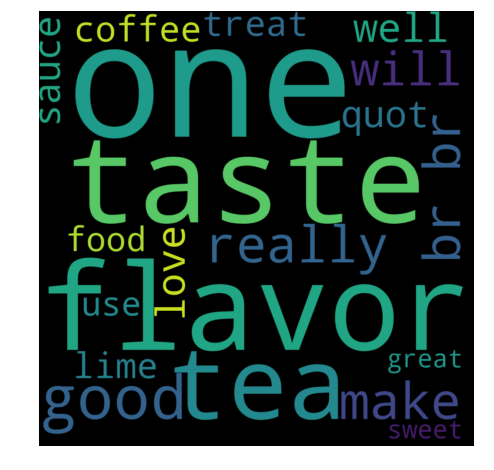

Word-cloud for cluster- 1


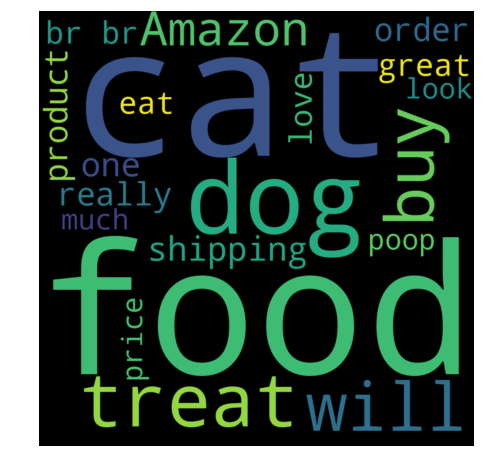

In [0]:
cluster_0=list(cluster_0)[:50]
cluster_1=list(cluster_1)[:50]

clusters=(cluster_0,cluster_1)
for i in range(0,2):
        print("Word-cloud for cluster-",i)
        text=""
        for x in clusters[i]:
             text = text + " " + x
        wordcloud = WordCloud(width=1000, height=1000, max_words=20).generate(text) 

        plt.figure(figsize=(8,8))
        plt.subplot()
        plt.imshow(wordcloud, interpolation="bilinear") 
        plt.axis("off") 
        plt.margins(x=0, y=0) 
        plt.show() 


**CLUSTER REPRESENTATION**

CLUSTER 0 : POSITIVE ADJECTIVES REALTED TO FOOD <BR>
CLUSTER 1: PRODUCT REALTED WORDS<BR>

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [0]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=50).fit(sent_vectors_10k)
distances, indices = nbrs.kneighbors(sent_vectors_10k)

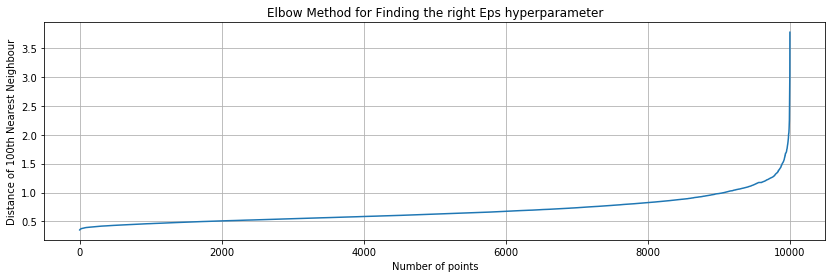

In [0]:
distanceDec = sorted(distances[:,49])
plt.figure(figsize=(14,4))
plt.grid()
plt.title("Elbow Method for Finding the right Eps hyperparameter")
plt.plot([x for x in range(10000)], distanceDec)
plt.xlabel("Number of points")
plt.ylabel("Distance of 100th Nearest Neighbour")
plt.show()

**Point of inflexion is around 1 and 1.5, we will go with 1.2**

In [0]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=1.2, min_samples=100).fit(sent_vectors_10k)




In [0]:
labels=final.iloc[:10000]
labels["Cluster"]=model.labels_


**Number of words per culster**

In [0]:
labels["Cluster"].value_counts()

 0    9933
-1      67
Name: Cluster, dtype: int64

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [0]:
cluster_0=labels.iloc[labels.groupby(["Cluster"]).groups[-1]]["Text"]
cluster_1=labels.iloc[labels.groupby(["Cluster"]).groups[0]]["Text"]

Word-cloud for cluster- 0


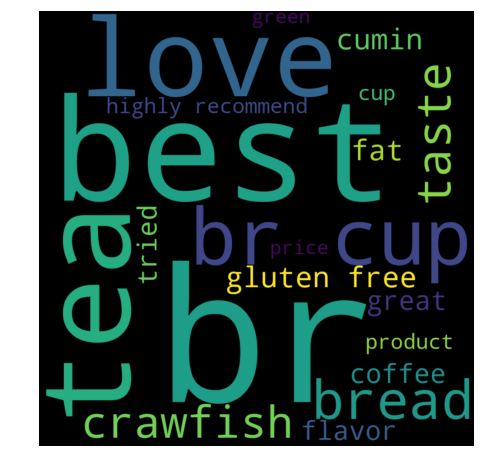

Word-cloud for cluster- 1


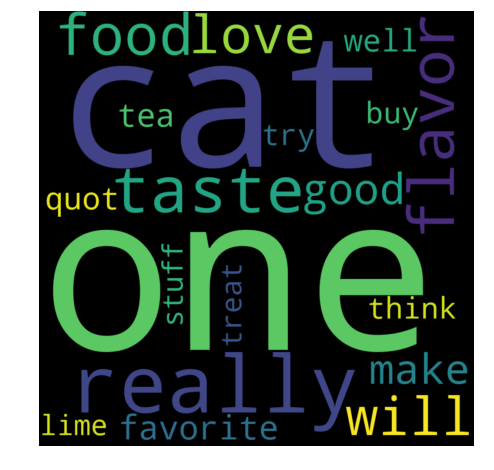

In [0]:
cluster_0=list(cluster_0)[:50]
cluster_1=list(cluster_1)[:50]

clusters=(cluster_0,cluster_1)
for i in range(0,2):
        print("Word-cloud for cluster-",i)
        text=""
        for x in clusters[i]:
             text = text + " " + x
        wordcloud = WordCloud(width=1000, height=1000, max_words=20).generate(text) 

        plt.figure(figsize=(8,8))
        plt.subplot()
        plt.imshow(wordcloud, interpolation="bilinear") 
        plt.axis("off") 
        plt.margins(x=0, y=0) 
        plt.show() 

**CLUSTER REPRESENTATION**

CLUSTER 0 : POSTIVE ADJECTIVES WITH FOOD ITEMS<BR>
CLUSTER 1: POSTIVE ADJECTIVES AND NUANCED WORDS<BR>

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
nbrs = NearestNeighbors(n_neighbors=50).fit(tfidf_sent_vectors_10k)
distances, indices = nbrs.kneighbors(tfidf_sent_vectors_10k)

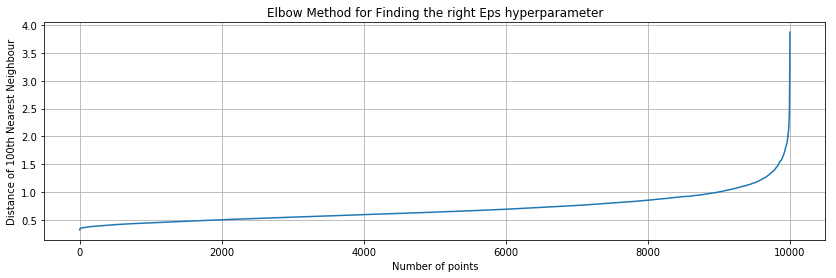

In [0]:
distanceDec = sorted(distances[:,49])
plt.figure(figsize=(14,4))
plt.grid()
plt.title("Elbow Method for Finding the right Eps hyperparameter")
plt.plot([x for x in range(10000)], distanceDec)
plt.xlabel("Number of points")
plt.ylabel("Distance of 100th Nearest Neighbour")
plt.show()

**Point of inflexion is around 1 and 1.5, we will go with 1**

In [0]:
model = DBSCAN(eps=1, min_samples=100).fit(sent_vectors_10k)

In [0]:
labels=final.iloc[:10000]
labels["Cluster"]=model.labels_

**Number of words per culster**

In [0]:
labels["Cluster"].value_counts()

 0    9742
-1     258
Name: Cluster, dtype: int64

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

In [0]:
cluster_0=labels.iloc[labels.groupby(["Cluster"]).groups[-1]]["Text"]
cluster_1=labels.iloc[labels.groupby(["Cluster"]).groups[0]]["Text"]

Word-cloud for cluster- 0


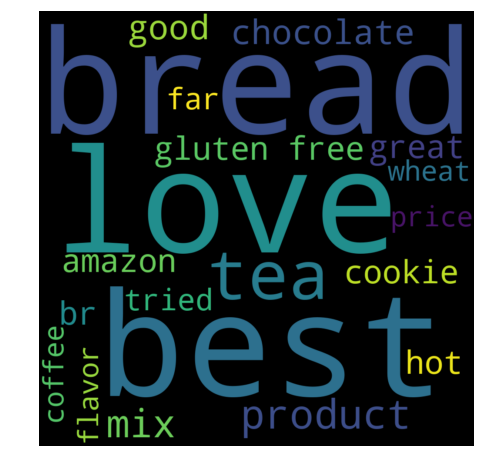

Word-cloud for cluster- 1


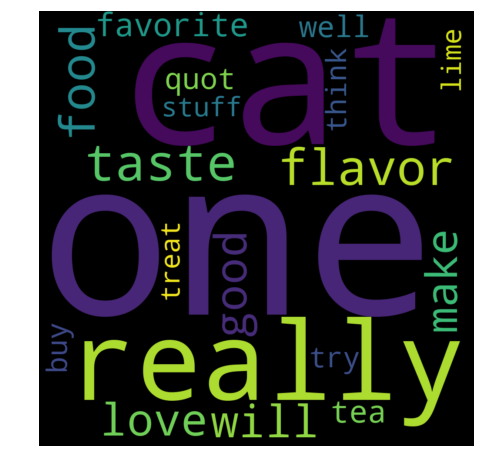

In [0]:
cluster_0=list(cluster_0)[:50]
cluster_1=list(cluster_1)[:50]

clusters=(cluster_0,cluster_1)
for i in range(0,2):
        print("Word-cloud for cluster-",i)
        text=""
        for x in clusters[i]:
             text = text + " " + x
        wordcloud = WordCloud(width=1000, height=1000, max_words=20).generate(text) 

        plt.figure(figsize=(8,8))
        plt.subplot()
        plt.imshow(wordcloud, interpolation="bilinear") 
        plt.axis("off") 
        plt.margins(x=0, y=0) 
        plt.show() 

**CLUSTER REPRESENTATION**

CLUSTER 0 : POSTIVE QUALITATIVE ADJECTIVES WITH FOOD ITEMS<BR>
CLUSTER 1: POSTIVE ADJECTIVES/NUANCED WORDS ASSOCIATED WITH PRODUCTS<BR>

# [6] Conclusions

**KMeans**

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","Optimal number of clusters","Inertia"]

x.add_row(["BOW","10","788919.12"])
x.add_row(["TFIDF","10","14455.84"])
x.add_row(["AVF WORD2VEV","10","74479"])
x.add_row(["TFIDF-W2V","10","96446.711"])



  
print(x)  

+--------------+----------------------------+-----------+
|    Model     | Optimal number of clusters |  Inertia  |
+--------------+----------------------------+-----------+
|     BOW      |             10             | 788919.12 |
|    TFIDF     |             10             |  14455.84 |
| AVF WORD2VEV |             10             |   74479   |
|  TFIDF-W2V   |             10             | 96446.711 |
+--------------+----------------------------+-----------+


1.The optimal number of cluster is 10 for all the vectorizers
2.The best clustering result comes out for TFIDF which has the     least Inertia 

**AGGLOMERATIVE CLUSTERING**

In [0]:

    
x = PrettyTable()

x.field_names = ["Model","Number of clusters","Algorithm"]

x.add_row(["BOW","2","WARD"])
x.add_row(["TFIDF","2","WARD"])
x.add_row(["AVF WORD2VEV","2","WARD"])
x.add_row(["TFIDF-W2V","2","WARD"])



  
print(x)  

+--------------+--------------------+-----------+
|    Model     | Number of clusters | Algorithm |
+--------------+--------------------+-----------+
|     BOW      |         2          |    WARD   |
|    TFIDF     |         2          |    WARD   |
| AVF WORD2VEV |         2          |    WARD   |
|  TFIDF-W2V   |         2          |    WARD   |
+--------------+--------------------+-----------+


**DBSCAN**

In [0]:
x = PrettyTable()

x.field_names = ["Model","Min_pts","eps"]

x.add_row(["AVF WORD2VEV","100","1.2"])
x.add_row(["TFIDF-W2V","100","1"])



  
print(x)  

+--------------+---------+-----+
|    Model     | Min_pts | eps |
+--------------+---------+-----+
| AVF WORD2VEV |   100   | 1.2 |
|  TFIDF-W2V   |   100   |  1  |
+--------------+---------+-----+


We see that the point of inflexion lies between 1 to 1.5